# Homework 4: ACS Income Prediction

This homework assignment guides you through building and evaluating machine learning models to predict individual income using the American Community Survey (ACS) microdata. You will implement both an XGBoost model and a fully connected neural network using Keras, following the workflows demonstrated in the provided tutorials. The focus will be on log-transforming the income target, feature engineering, model training, and evaluation.

## Setup

### Data
Use the ACS microdata file `usa_00005.dta` that I shared on Populi. This dataset contains individual-level records with demographic and socioeconomic features, including total personal income (`inctot`).

## Task 1: Load and Log-transform ACS Data

Following the final attempt in the XGBoost tutorial, sample 10% of the microdata, drop any rows where `inctot == 9999999`.

In [9]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load data
data = pd.read_stata("/Users/keith/Documents/code/Intro to ML 2025/data/raw/usa_00005.dta")

# Sample 10%
data = data.sample(frac=0.1, random_state=42).reset_index(drop=True)

# Drop rows with missing income (9999999)
data = data[data['inctot'] != 9999999]
print(f"Data shape after dropping missing income: {data.shape}")    

Data shape after dropping missing income: (289210, 144)


**Question 1:** Why is it not necessary to impute or filter our missing values for other features?

**Answer 1:** XGBoost handles missing values natively. When a value is missing, the tree learns a default direction for that specific split that minimizes the loss function. Therefore, explicit imputation is often unnecessary unless we have specific domain knowledge about why the data is missing

### Task 1.1: Log-transform Income

Instead of predicting income directly, we will predict log-income.
Create a new target column `log_inctot` by applying the natural log transformation to `inctot` after adding 1 (i.e., `np.log1p`).
Filter out any rows where `inctot` is less than or equal to zero before applying the log transformation.
Make a histogram of both the original income and log-income distributions to visualize the effect of the transformation.

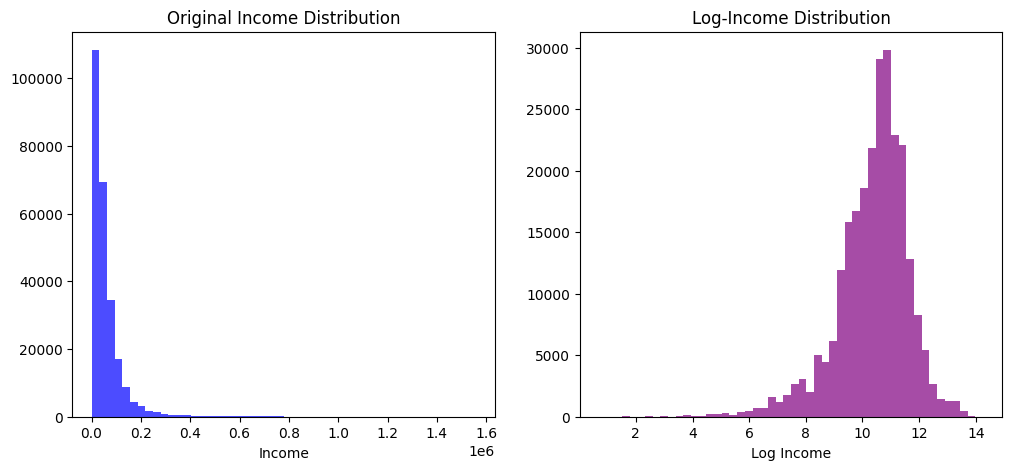

In [14]:
# Filter out non-positive income values
data = data[data['inctot'] > 0]

# Log-transform income
data['log_inctot'] = np.log1p(data['inctot'])

# Visualize original and log-transformed income distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(data['inctot'], bins=50, color='blue', alpha=0.7)
plt.title('Original Income Distribution')
plt.xlabel('Income')

plt.subplot(1, 2, 2)
plt.hist(data['log_inctot'], bins=50, color='purple', alpha=0.7)
plt.title('Log-Income Distribution')
plt.xlabel('Log Income')

plt.show()

**Question 2:** What are the advantages of predicting log-income rather than income directly?

**Answer 2:** Income data can be lopsided due to the disparity because the majority of the population and billionares. These extreme high-earners can confuse the model, causing it to focus too much on them rather than the average person. Using a log transformation smooths out these extremes, making the data easier for the model to understand and predict accurately.

## Task 2: Feature Engineering and Encoding
Split the data into a feature matrix `X` and target vector `y` (the log-income column created above). Perform one-hot encoding on all categorical features, dropping sparse columns whose proportion of non-zero entries falls below 1%.
The feature matrix `X` should include all columns except `inctot` and `log_inctot`.
The target vector `y` should be the `log_inctot` column.
Mimic the one-hot encoding workflow from the tutorial: build dummies for every categorical column in `X`, then drop sparse columns whose proportion of non-zero entries falls below 1%.

In [16]:
# Split features and target
y = data['log_inctot']
X = data.drop(columns=['inctot', 'log_inctot'])

# Hot-encode 
X_encoded = pd.get_dummies(X, drop_first=False)

# Drop sparse columns (< 1% non-zero entries)
cols_to_keep = [col for col in X_encoded.columns if (X_encoded[col] != 0).mean() > 0.01]
X_encoded = X_encoded[cols_to_keep]

print(f"Shape after encoding and pruning: {X_encoded.shape}")

Shape after encoding and pruning: (253800, 695)


### Task 2.1: Train/Test Split
Split the encoded data into training and testing sets (80/20).

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

## Task 3: XGBoost Modeling (Log Target)
Reproduce the final modeling attempt from `examples/XGBoost.ipynb`, but treat the log-income target as the label. Work through the following subtasks and insert your own code in each block.

### Task 3.1: Build DMatrix Objects
Create `xgb.DMatrix` objects for both the training and test splits using the log-income labels.

In [18]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

### Task 3.2: Hyperparameter Dictionary
Start from the tutorial’s baseline settings (e.g., `eta = 1`, `max_depth = 10`, `min_child_weight = 100`, RMSE metric, early stopping after 50 rounds) and justify any deviations you make.
Use the `reg:squarederror` objective and `rmse` evaluation metric.

In [19]:
# Baseline parameters
params = {
    'eta': 1,                 
    'max_depth': 10,          
    'min_child_weight': 100, 
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'verbosity': 0
}

### Task 3.3: Hyperparameter Tuning

Perform a grid search over the `eta = [1, 0.1, 0.01]` and `max_depth = [3, 6, 10]` parameters to identify the best combination based on validation RMSE (i.e., for each combination of `eta` and `max_depth`, train a model and record the validation RMSE).
Use early stopping with a patience of 50 rounds and a maximum of 10,000 training rounds.

In [20]:
eta_vals = [1, 0.1, 0.01]
max_depth_vals = [3, 6, 10]
best_rmse = float("inf")
best_params = {}

results = []

for eta in eta_vals:
    for depth in max_depth_vals:
        # Update params
        current_params = params.copy()
        current_params['eta'] = eta
        current_params['max_depth'] = depth
        
        # Train
        # We use the eval list to watch validation performance
        evallist = [(dtrain, 'train'), (dtest, 'eval')]
        
        model = xgb.train(
            current_params,
            dtrain,
            num_boost_round=10000,
            evals=evallist,
            early_stopping_rounds=50,
            verbose_eval=False
        )
        
        # best_score gives the best rmse found during training
        val_rmse = model.best_score
        results.append((eta, depth, val_rmse))
        print(f"Eta: {eta}, Depth: {depth}, RMSE: {val_rmse}")
        
        if val_rmse < best_rmse:
            best_rmse = val_rmse
            best_params = current_params
            best_model = model

print(f"\nBest Params: eta={best_params['eta']}, depth={best_params['max_depth']}")
print(f"Best Validation RMSE: {best_rmse}")

Eta: 1, Depth: 3, RMSE: 0.8287956838307373
Eta: 1, Depth: 6, RMSE: 0.8496526069055117
Eta: 1, Depth: 10, RMSE: 0.8550343552675418
Eta: 0.1, Depth: 3, RMSE: 0.8050965173165748


KeyboardInterrupt: 

**Question 3:** Which hyperparameter combination yielded the lowest validation RMSE, and what was that RMSE value?
Based on the results, do you think you need to expand the grid search other values or parameters?
(Note: You do not need to actually search for more parameters, just discuss.)

### Task 3.4: Final Model Training
Using the best hyperparameters from Task 3.3, train a final XGBoost model on the full dataset.

### Task 3.5: Evaluate Predictions
Plot predicted vs. actual log-income values on the test set using a scatter plot.

**Question 4:** Qualitatively, how well do the predictions align with the actual values?

## Task 4: Neural Network Modeling (Keras)
Use the structure from `examples/neural_nets_simple.ipynb` to fit a fully connected neural network on the same encoded features and log-income target.
Use the same train/test split as in Task 2.1.

### Task 4.1: Prepare Data for Keras
If necessary, convert the training and test feature matrices and target vectors into NumPy arrays suitable for Keras.
__Note:__ You may have already done this in Task 2.1.

### Task 4.2: Define the Architecture
Implement a dense network with several ReLU-activated hidden layers (e.g., 256-128-64) and compile it with the Adam optimizer and MSE loss.

**Question 5:** What should the input dimension be for the first layer of the network be?

### Task 4.3: Initial Training
Fit the model on the training data while validating on the test set.
Run the training for a maximum of 1,000 epochs.
I have some example code below that includes early stopping to prevent overfitting.
You may adjust as needed.
The `patience` parameter in the `EarlyStopping` callback controls how many epochs with no improvement on the validation loss to wait before stopping training.
The `batch_size` is a parameter that we haven't discussed in class, but it limits the amount of data the model is exposed to at once during training.
You can leave it at 1024 for this assignment.

In [ ]:
# history = nn_model.fit(
#     X_train_arr,
#     y_train_arr,
#     validation_data=(X_test_arr, y_test_arr),
#     epochs=1000,
#     batch_size=1024,
#     verbose=1,
#     callbacks=[
#         keras.callbacks.EarlyStopping(
#             monitor="val_loss",
#             patience=10,
#             restore_best_weights=True,
#         )
#     ],
# )

#### Task 4.3a
Plot the training and validation loss curves over epochs.

**Question 6:** Based on the loss curves, does the model appear to be underfitting, overfitting, or well-fitted? Justify your answer.

### Task 4.4: Model Tuning
The neural network architecture and training parameters can significantly impact performance.
The architecture consists of the number of layers, layer dimensions, and activation functions.
Create three different architectures: the one from Task 4.2, a deeper/wider one, and a shallower/narrower one.
Additionally, consider three different learning rates: `1e-3`, `1e-4`, and `1e-5`.
Perform a grid search over these architectures and learning rates to identify the best combination based on validation loss.
__Hint:__ Save the models and their histories in a dictionary for easy comparison later.

**Question 7:** Which architecture and learning rate combination yielded the lowest validation loss, and what was that loss value?

### Task 4.5: Evaluate Predictions
Generate predictions on the test set using the best model from Task 4.
Create a scatter plot of predicted vs. actual log-income values.

## Task 5: Model Comparison and Reflection
Which model would you choose for predicting log-income on new ACS data: the XGBoost model from Task 3 or the neural network from Task 4? Why?